In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Computation
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import wave

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

%matplotlib inline

# Samples and Sampling Rate 

Checking if the training and testing data have the same sampling rate and samples.

In [5]:
train_audio_path = 'train/audio'
test_audio_path = 'test/audio'

folders_tr = os.listdir(train_audio_path)
files_ts = os.listdir(test_audio_path)

sr_tr = []
sr_ts = []

s_tr =[]
s_ts =[]

for folder in folders_tr:
    audio_class_folder = os.path.join(train_audio_path,folder)
    files = os.listdir(audio_class_folder)
    for file in files:
        sample_rate_tr, samples_tr = wavfile.read(os.path.join(audio_class_folder,file))
        sr_tr.append(sample_rate_tr)
        s_tr.append(len(samples_tr))
for file in files_ts:
    sample_rate_ts, samples_ts = wavfile.read(os.path.join(test_audio_path,file))
    sr_ts.append(sample_rate_ts)
    s_ts.append(len(samples_ts))
    
print('Training sampling rate = ',int(np.unique(np.asarray(sr_tr))),'Hz, Testing sampling rate =', int(np.unique(np.asarray(sr_ts))),'Hz')
print('Training samples = ',(np.unique(np.asarray(s_tr))),'\n''Testing samples =', (np.unique(np.asarray(s_ts))))

We find that although both training and testing set audio files have the same sampling rate, the number of samples and hence the duration of the audio waves varies in the training set.

Now we know that that all the .wav files in both the training and testing sets are sampled at 16000 Hz. By Nyquist theorem, the maximum frequency content in these audio clips will be 8000 Hz. Let us now analyse the distribution of amplitude and frequencies across time of a random audio signal.

In [76]:
def plot_wave_spec(audio_path, audio_file , window_size=20,
                 step_size=10, eps=1e-10):
    sample_rate, samples = wavfile.read(os.path.join(audio_path,audio_file))
    nperseg = int(round(window_size * sample_rate / 1e3)) # number of samples in a window segment
    noverlap = int(round(step_size * sample_rate / 1e3))  # hop size in terms of samples
    freqs, times, spec = signal.spectrogram(samples,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    log_spectrogram = np.log(spec.T.astype(np.float64) + eps)
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + audio_file)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, len(samples)/sample_rate, len(samples)),samples)
    ax2 = fig.add_subplot(212)
    ax2.imshow(log_spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), round(times.max()), freqs.min(), freqs.max()], cmap = 'magma')
    ax2.set_title('Log Spectrogram of ' + audio_file)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')
    print('Number of frequency features = ',log_spectrogram.shape[1])

Number of frequency features =  161


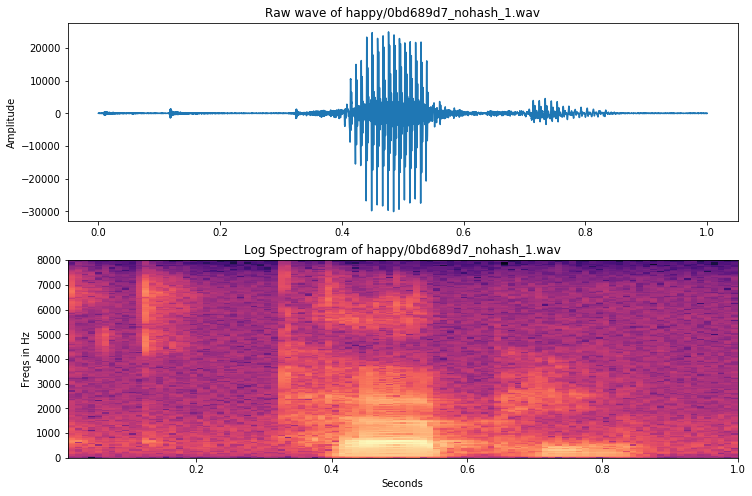

In [77]:
file_train1 = 'happy/0bd689d7_nohash_1.wav'
file_train2 = 'no/0bd689d7_nohash_0.wav'

file_test = 'clip_0000adecb.wav'
plot_wave_spec(train_audio_path,file_train1)

add colorbar

Humans, although able to hear sounds of frequencies in the range 20Hz-20kHz, are most sensitive to frequencies between 2kHz and 5kHz. There are around 160 spectral features for a range of 0 Hz to 8000 Hz, the log spectrogram above, which gives a resolution of 50Hz per feature. But the human auditary resolution is 3.6Hz between 1kHz-2kHz. So we need features that have better resolution. 

Mel-Frequency Cepstral Coefficients (MFCC) are very useful in speech recognition as the mel scale is representitive of the human perceptual scale of pitches. MFCCs are calculated by treating the log spectrum of a signal as the signal.